# Defending against Data Poisoning Attacks in Federated Learning

### Imports

In [ ]:
import copy
import numpy as np
from tqdm import tqdm

import pickle
import torch

from update import LocalUpdate, test_inference
from models import CNNMnist, CNNCifar
from utils import *

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

### Attack settings and FL hyperparameters definition

In [2]:
n_train_epochs = 60
n_train_clients = 100
n_total_clients = 1000

mal_usr_percentage = 0
target_hon = 5
target_mal = 9

dataset = 'cifar'
client_lr = 0.001
client_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

mal = [0, 10, 20, 30, 40]


NVIDIA GeForce GTX 1080 Ti


### Data loading and manipulation

In [5]:
# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, n_train_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))

train_loss_total = []
train_accuracy_total = []
train_recall_total = []

test_loss_total = []
test_accuracy_total = []
test_recall_total = []

attacker_detection_ratio = []

### OPTIONAL: Save the model ###

# if dataset == 'mnist':
#     global_model = CNNMnist()
# elif dataset == 'cifar':
#     global_model = CNNCifar()

# # Saving:
# torch.save({
#     'model': global_model,
# }, 'cifar100.pth')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
attack = [0, 1]
recalls = []

mal = [0, 10, 20, 30, 40, 50]

## Attack the model with many different percentages of malicious users

In [ ]:
# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, n_train_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))


for mal_usr_percentage in mal:
    
    train_dataset, _, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, n_train_clients, dataset)

    checkpoint = torch.load('../mnist.pth')
    global_model = checkpoint['model']
    global_model.load_state_dict(global_model.state_dict())

    attack_ratio = 0
    
    print("Running experiment with " + str(mal_usr_percentage) + "% malicious clients")

    # Send the model to the device and then set it to train mode
    global_model.to(device)
    global_model.train()

    # hold the initial global weights
    global_weights = global_model.state_dict()
    
    train_loss , train_accuracy, train_recall = [], [], []
    test_loss , test_accuracy, test_recall = [], [], []


    for epoch in tqdm(range(n_train_epochs)):
        selected_users = clients[epoch]
            
        local_weights, local_losses = [], []
        
        for user in selected_users:
            local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

            w, loss = local_model.update_weights(
                model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
            
            local_weights.append(copy.deepcopy(w))
            local_losses.append(copy.deepcopy(loss))
        
        loss_avg = sum(local_losses) / len(selected_users)
        
        train_loss_total.append(loss_avg)
        
        # update global weights
        global_weights = average_weights(local_weights)
        # update global weights
        global_model.load_state_dict(global_weights)

        # Calculate avg training accuracy over all users at every epoch
        train_acc = 0
        train_rec = 0
        # evaluation mode of the model
        global_model.eval()

        for client in selected_users:
            local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
            
            acc, loss, rec = local_model.inference(model = global_model)
            train_acc += acc
            train_rec += rec
            
        train_acc /= len(selected_users)
        train_rec /= len(selected_users)
        
        train_accuracy.append(train_acc)
        train_recall.append(train_rec)

        # Test inference after each epoch
        test_acc, test_ls, test_rec = test_inference(global_model, test_dataset, target_mal)

        test_accuracy.append(test_acc)
        test_loss.append(test_ls)
        test_recall.append(test_rec)   
    
    test_accuracy_total.append(test_accuracy)    
    test_loss_total.append(test_loss)    
    test_recall_total.append(test_recall)    


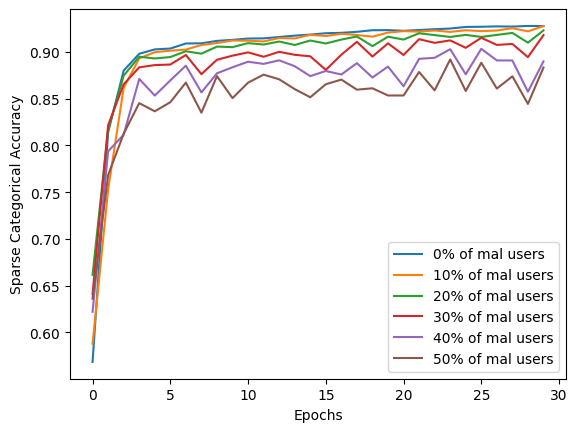

In [7]:
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(test_accuracy_total):

    plt.plot(epochs, model_acc, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.show()

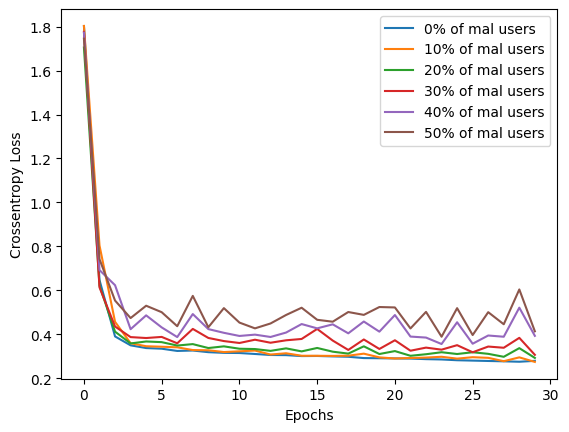

In [8]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(test_loss_total):

    plt.plot(epochs, model_loss, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Crossentropy Loss")
plt.legend()
plt.show()

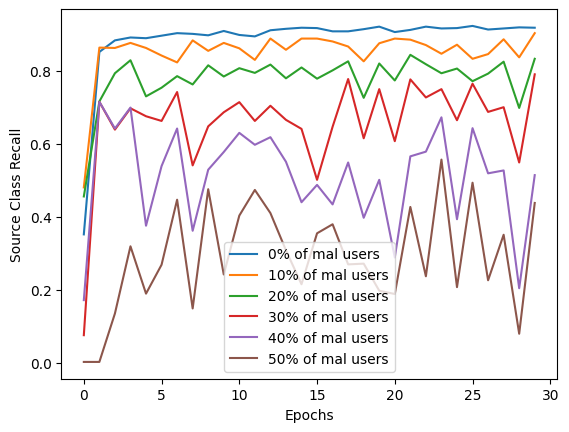

In [9]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_rec in enumerate(test_recall_total):

    plt.plot(epochs, model_rec, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")
plt.legend()
plt.show()

## Apply the novel defense algorithm to eliminate the malicious users

In [3]:
attacker_detection_ratio = []
train_loss_total = []
train_accuracy_total = []
train_recall_total = []

test_loss_total = []
test_accuracy_total = []
test_recall_total = []

attackers_accuracy_total = []
attackers_f1_total = []

In [ ]:
attack = [1]
recalls = []

mal = [0, 10, 20, 30, 40]

for att in attack:
    last_epoch_recall = []

    for mal_usr_percentage in mal:
        
        train_dataset, _, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, n_train_clients, dataset)

        checkpoint = torch.load('cifar.pth')
        global_model = checkpoint['model']
        global_model.load_state_dict(global_model.state_dict())

        attack_ratio = 0
        
        print("Running experiment with " + str(mal_usr_percentage) + "% malicious clients")

        # Send the model to the device and then set it to train mode
        global_model.to(device)
        global_model.train()
    
        # hold the initial global weights
        global_weights = global_model.state_dict()
        
        train_loss , train_accuracy, train_recall = [], [], []
        test_loss , test_accuracy, test_recall = [], [], []

        attackers_accuracy, attackers_f1 = [], []

        for epoch in tqdm(range(n_train_epochs)):
            if att == 1:
                local_weights_fake, local_losses_fake = [], []
                
                global_model.train()
            
                selected_users = clients[epoch]

                for user in selected_users:
                    local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

                    w, loss = local_model.update_weights(
                        model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr, fake=True)
                    
                    local_weights_fake.append(copy.deepcopy(w))
                    local_losses_fake.append(copy.deepcopy(loss))

                
                local_losses_fake = apply_ldp(local_losses_fake, epsilon=1.0, sensitivity=0.0001)
                
                info = (local_losses_fake, local_weights_fake, selected_users)
                
                selected_users, attackers_found = eliminate_kmeans(info)
                            
                count = sum(1 for item in attackers_found if item in attackers)
                
                if mal_usr_percentage > 0 and att == 1:
                    attack_ratio += (count / ((mal_usr_percentage / 100) * n_train_clients))
                    
                    
                    # epoch_attackers  = list(set(attackers) & set(selected_users))
                    attackers_accuracy.append(calculate_accuracy(attackers_found, attackers, selected_users))
                    attackers_f1.append(calculate_f1_score(attackers_found, attackers))
                    
            elif att == 0:
                selected_users = clients[epoch]
                
            local_weights, local_losses = [], []
            
            for user in selected_users:
                local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

                w, loss = local_model.update_weights(
                    model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
                
                local_weights.append(copy.deepcopy(w))
                local_losses.append(copy.deepcopy(loss))
            
            loss_avg = sum(local_losses) / len(selected_users)
            
            train_loss_total.append(loss_avg)
            
            # update global weights
            global_weights = average_weights(local_weights)
            # update global weights
            global_model.load_state_dict(global_weights)

            # Calculate avg training accuracy over all users at every epoch
            train_acc = 0
            train_rec = 0
            # evaluation mode of the model
            global_model.eval()

            for client in selected_users:
                local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
                
                acc, loss, rec = local_model.inference(model = global_model)
                train_acc += acc
                train_rec += rec
                
            train_acc /= len(selected_users)
            train_rec /= len(selected_users)
            
            train_accuracy.append(train_acc)
            train_recall.append(train_rec)

            # Test inference after each epoch
            test_acc, test_ls, test_rec = test_inference(global_model, test_dataset, target_mal)

            test_accuracy.append(test_acc)
            test_loss.append(test_ls)
            test_recall.append(test_rec)
            
        
        last_epoch_recall.append(test_recall[-1])
        
        if att == 1:
            attack_ratio /= n_train_epochs
            if attack_ratio > 1:
                attack_ratio = 1
                
            if mal_usr_percentage > 0:
                attackers_accuracy_total.append(sum(attackers_accuracy) / len(attackers_accuracy))
                attackers_f1_total.append(sum(attackers_f1) / len(attackers_f1))
                print(attackers_accuracy)
                print(attackers_f1)
                
            attacker_detection_ratio.append(attack_ratio)
            train_accuracy_total.append(train_accuracy)
            train_loss_total.append(train_loss)
            train_recall_total.append(train_recall)

            test_accuracy_total.append(test_accuracy)
            test_loss_total.append(test_loss)
            test_recall_total.append(test_recall)

    recalls.append(last_epoch_recall)


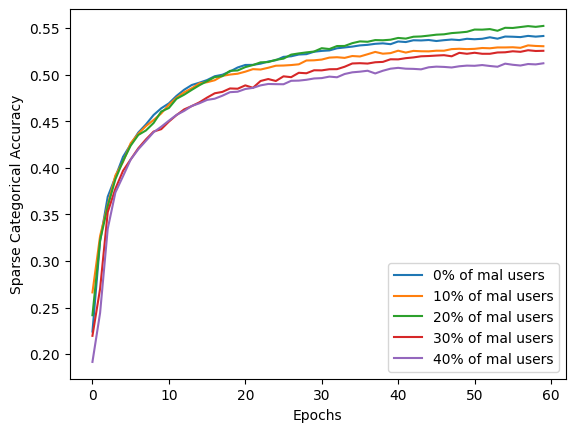

In [7]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(test_accuracy_total):

    plt.plot(epochs, model_acc, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.show()

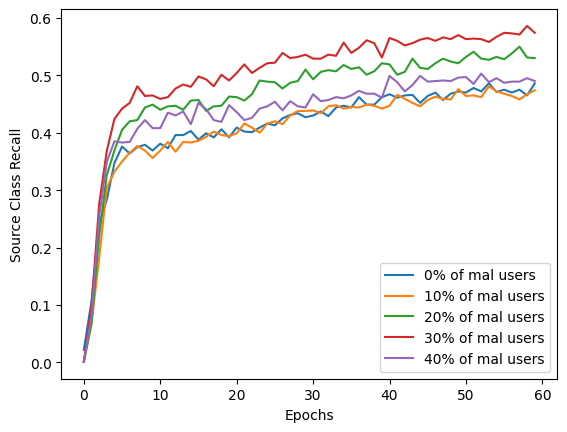

In [9]:
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_rec in enumerate(test_recall_total):

    plt.plot(epochs, model_rec, label = str(mal[cnt]) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")
plt.legend()
plt.show()